# Overview

In this exercise I started with manually programming a decision tree designed to navigate a simple data set of vehicle miles per gallon, number of cylinders, horsepower, and weight. The goal was to properly classify the MPG ratings of the vehicles in the data based on the categories cylinders, HP, and weight class.

Toward the end of the exercise, I train a random forest classifier on the same data and assess the accuracy of the model given various tuning parameters.

### Manual decision tree

In [1]:
# Setup
import pandas as pd
import numpy as np

In [2]:
# Sample data
from StringIO import StringIO
thefile = StringIO('MPG,cylinders,HP,weight\ngood,4,75,light\nbad,6,90,medium\nbad,4,110,medium\nbad,8,175,weighty\nbad,6,95,medium\nbad,4,94,light\nbad,4,95,light\nbad,8,139,weighty\nbad,8,190,weighty\nbad,8,145,weighty\nbad,6,100,medium\ngood,4,92,medium\nbad,6,100,weighty\nbad,8,170,weighty\ngood,4,89,medium\ngood,4,65,light\nbad,6,85,medium\ngood,4,81,light\nbad,6,95,medium\nbad,4,93,light')
df = pd.read_csv(thefile)
df

,MPG,cylinders,HP,weight
0,good,4,75,light
1,bad,6,90,medium
2,bad,4,110,medium
3,bad,8,175,weighty
4,bad,6,95,medium
5,bad,4,94,light
6,bad,4,95,light
7,bad,8,139,weighty
8,bad,8,190,weighty
9,bad,8,145,weighty


### Most common MPG

In [3]:
# most common MPG
good = 0
bad = 0
for row in df.iterrows():
    if row[1]['MPG'] == 'good':
        good += 1
    else:
        bad += 1

if good > bad:
    print("The most common MPG value is good")
else:
    print("The most common MPG value is 'bad'")

The most common MPG value is 'bad'


### Functions to determine possible splits

In [4]:
# Information gain function used to decide which variable/value to use at each node of the decision tree
def InformationGain(goodY,badY,goodN,badN):
    def F(X,Y):
        val1 = X*np.log2(1.*(X+Y)/X) if X>0 else 0
        val2 = Y*np.log2(1.*(X+Y)/Y) if Y>0 else 0
        return val1+val2
    return (F(goodY+goodN,badY+badN)-F(goodY,badY)-F(goodN,badN)) / (goodY+goodN+badY+badN)

In [5]:
# Cylinder splits
def cylcheck(df):
    cyls = list(df.cylinders.unique())
    d = {}
    for cyl in cyls:
        goodY = 0
        badY = 0
        goodN = 0
        badN = 0
        for row in df.iterrows():
            if row[1]['cylinders'] == cyl:
                if row[1]['MPG'] == 'good':
                    goodY += 1
                else:
                    badY += 1                
            else:
                if row[1]['MPG'] == 'good':
                    goodN += 1
                else:
                    badN += 1
        lst = [goodY, badY, goodN, badN]
        info_gain = InformationGain(goodY, badY, goodN, badN)
        d[cyl] = tuple([lst,info_gain])
    return d

In [6]:
# Weight splits
def weight_check(df):
    weights = list(df.weight.unique())
    d = {}
    for weight in weights:
        goodY = 0
        badY = 0
        goodN = 0
        badN = 0
        for row in df.iterrows():
            if row[1]['weight'] == weight:
                if row[1]['MPG'] == 'good':
                    goodY += 1
                else:
                    badY += 1                
            else:
                if row[1]['MPG'] == 'good':
                    goodN += 1
                else:
                    badN += 1
        lst = [goodY, badY, goodN, badN]
        info_gain = InformationGain(goodY, badY, goodN, badN)
        d[weight] = tuple([lst,info_gain])
    return d

In [7]:
# Horsepower splits
def hpsplits(df):
    df = df.sort_values(by='HP')
    df['previous_MPG'] = df['MPG'].shift(1)
    df['previous_HP'] = df['HP'].shift(1)
    
    dfsplits = []
    for index, row in df.iloc[1:].iterrows():
        if row['MPG'] != row['previous_MPG']:
            split = (row['HP'] + row['previous_HP'])/2
            dfsplits.append(split)
    
    d = {}
    for split in dfsplits:
        goodY = 0
        badY = 0
        goodN = 0
        badN = 0
        for row in df.iterrows():
            if row[1]['HP'] > split:
                if row[1]['MPG'] == 'good':
                    goodY += 1
                else:
                    badY += 1                
            else:
                if row[1]['MPG'] == 'good':
                    goodN += 1
                else:
                    badN += 1
        lst = [goodY, badY, goodN, badN]
        info_gain = InformationGain(goodY, badY, goodN, badN)
        d[split] = tuple([lst,info_gain])
    return d

In [8]:
cylcheck_split = cylcheck(df)
print("Format: {Number of cylinders: ([Good and bad in first node and in second node], info gain)}")
cylcheck_split

Format: {Number of cylinders: ([Good and bad in first node and in second node], info gain)}


{4: ([5, 4, 0, 11], 0.36529389753193281),
 6: ([0, 6, 5, 9], 0.15307795338969116),
 8: ([0, 5, 5, 10], 0.12255624891826571)}

In [9]:
weight_split = weight_check(df)
print("Format: {Weight class: ([Good and bad in first node and in second node], info gain)}")
weight_split

Format: {Weight class: ([Good and bad in first node and in second node], info gain)}


{'light': ([3, 3, 2, 12], 0.097107179451503628),
 'medium': ([2, 6, 3, 9], 8.8817841970012528e-17),
 'weighty': ([0, 6, 5, 9], 0.15307795338969116)}

In [10]:
hp = hpsplits(df)
print("Format: {HP: ([Good and bad in first node and in second node], info gain)}")
hp

Format: {HP: ([Good and bad in first node and in second node], info gain)}


{83.0: ([2, 15, 3, 0], 0.36710265610273324),
 87.0: ([2, 14, 3, 1], 0.21417094500762929),
 89.5: ([1, 14, 4, 1], 0.36577659947122626),
 91.0: ([1, 13, 4, 2], 0.27592674559417307),
 92.5: ([0, 13, 5, 2], 0.50918592546081209)}

### Splitting the data

The optimal binary split comes from partitioning the data based on whether or not the HP is greater than 92.5. At this split, we have the greatest information gain (.51). Still, some further partitioning is required since some cars with less than or equal to 92.5 HP have good gas mileage and some have bad gas mileage and their other characteristics, such as weight and the number of cylinders, are not identical.

In [11]:
# First split on HP > 92.5 since info gain is greatest at that split
def first_split(df):
    mask = df['HP'] > 92.5
    df_yes = df[mask]
    df_no = df[~mask]
    return df_yes, df_no

In [12]:
# Get two dataframes, one that meets the condition for the first split and one that doesn't.
fs_df_yes = first_split(df)[0]
fs_df_no = first_split(df)[1]

In [13]:
# Meets first condition HP > 92.5
# All classified into one group of MPG (all bad) therefore no more splits necessary
fs_df_yes

,MPG,cylinders,HP,weight
2,bad,4,110,medium
3,bad,8,175,weighty
4,bad,6,95,medium
5,bad,4,94,light
6,bad,4,95,light
7,bad,8,139,weighty
8,bad,8,190,weighty
9,bad,8,145,weighty
10,bad,6,100,medium
12,bad,6,100,weighty


In [14]:
# Does not meet first condition HP > 92.5
# Still a mix of good and bad MPG so more splits necessary
fs_df_no

,MPG,cylinders,HP,weight
0,good,4,75,light
1,bad,6,90,medium
11,good,4,92,medium
14,good,4,89,medium
15,good,4,65,light
16,bad,6,85,medium
17,good,4,81,light


In [15]:
# To find the correct second split
cylcheck(fs_df_no)

{4: ([5, 0, 0, 2], 0.86312056856663089),
 6: ([0, 2, 5, 0], 0.86312056856663089)}

In [16]:
weight_check(fs_df_no)

{'light': ([3, 0, 2, 2], 0.29169199713805949),
 'medium': ([2, 2, 3, 0], 0.29169199713805949)}

In [17]:
hpsplits(fs_df_no)

{83.0: ([2, 2, 3, 0], 0.29169199713805949),
 87.0: ([2, 1, 3, 1], 0.0059777114237739171),
 89.5: ([1, 1, 4, 1], 0.061743357932800738),
 91.0: ([1, 0, 4, 2], 0.076009853662782872)}

In [18]:
# Since the highest information gain comes from checking the number of cylinders, will use that criterion
def second_split(df):
    mask = df['cylinders'] == 4
    df_yes = df[mask]
    df_no = df[~mask]
    return df_yes, df_no

In [19]:
ss_df_yes = second_split(fs_df_no)[0]
ss_df_no = second_split(fs_df_no)[1]

In [20]:
ss_df_yes

,MPG,cylinders,HP,weight
0,good,4,75,light
11,good,4,92,medium
14,good,4,89,medium
15,good,4,65,light
17,good,4,81,light


In [21]:
ss_df_no

,MPG,cylinders,HP,weight
1,bad,6,90,medium
16,bad,6,85,medium


### Classified data

All necessary splits have now been made and all the training data has been perfectly classified. From the first split on HP > 92.5, we were left with one group with all bad MPG and another group with some good and some bad MPG. After the second split on cylinders == 4, we were left with one group of all good MPG and another group of all bad MPG.

(See below for a graphical representation of the decision tree.)

In [22]:
from IPython.display import Image

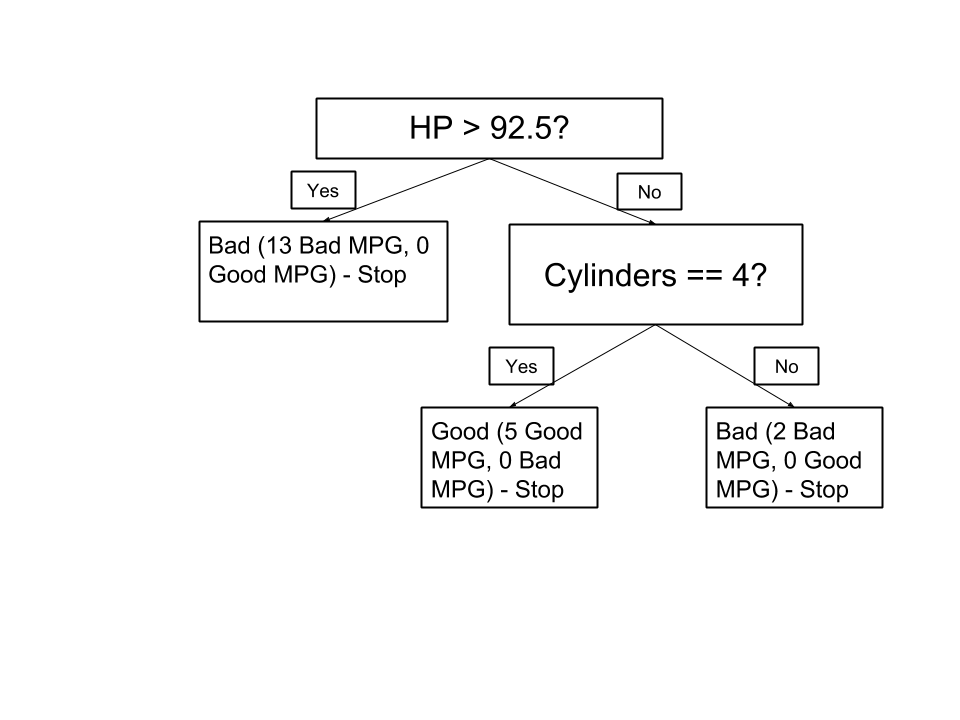

In [25]:
Image(filename = "images/decision_tree.png", width=500, height=500)

### Classifying new data

Let's say we had four new cars added to the data set but we didn't know their MPG ratings. 

**?**,8,70,light

**?**,6,113,medium

**?**,4,83,weighty

**?**,4,95,weighty

What should their MPG ratings be, given the decision tree above?

**Bad**,8,70,light

**Bad**,6,113,medium

**Good**,4,83,weighty

**Bad**,4,95,weighty

### Random forest with sklearn

Now that I've shown how to manually build a decision tree, I'm going to cheat and use sklearn to create decision tree and random forest models to model and predict on a sample data set of health and sanitation in various countries. In this exercise, the goal is to accurately predict values seen in the BurdenOfDisease column based on all other columns (excluding the "Country" column).

In [27]:
data=pd.read_csv("data/illness.csv")
data.head(10)

,Country,FrxnPeaceIn10,ODA4H2OPcptaDol,RenewResm3PcptaYr,SustAccImprWatRur,SustAccImprWatUrb,SustAccImprSanRur,SustAccImprSanUrb,TotHlthExpPctofGDP,GenGovtPctofTotHlthExp,ExtResHlthPctTotExpHlth,PCptaGovtExpHlthAvgExcRt,GDPPCptaIntDol,AdultLtrcyRate,FemaleLtrcyRate,BurdenOfDisease
0,Afghanistan,0.1,0.16,2986,0.10891,0.18812,0.049505,0.15842,0.065,0.395,0.4560,4,430,0.35644,0.20792,awful
1,Albania,1.0,5.58,13306,0.94059,0.98020,0.801980,0.98020,0.065,0.417,0.0340,49,6158,0.85644,0.78713,low
2,Algeria,0.0,0.33,473,0.79208,0.91089,0.811880,0.98020,0.041,0.808,0.0005,71,4860,0.69307,0.60396,high
3,Angola,0.2,0.63,14009,0.39604,0.69307,0.158420,0.55446,0.028,0.842,0.0670,22,1942,0.66139,0.53267,awful
4,Armenia,1.0,2.51,2780,0.79208,0.98020,0.603960,0.95050,0.060,0.202,0.1720,11,5697,0.97624,0.97030,low
5,Australia,1.0,0.00,25708,0.99010,0.99010,0.990100,0.99010,0.095,0.675,0.0005,1699,31454,0.98020,0.98020,low
6,Azerbaijan,0.9,1.30,3765,0.58416,0.94059,0.356440,0.72277,0.036,0.238,0.0190,8,4337,0.97822,0.97228,medium
7,Bahamas,1.0,0.00,66,0.85149,0.97030,0.990100,0.99010,0.064,0.475,0.0020,533,19930,0.94653,0.95545,low
8,Bangladesh,1.0,0.47,8809,0.71287,0.81188,0.386140,0.74257,0.034,0.313,0.1240,4,2098,0.42673,0.31485,high
9,Barbados,1.0,0.17,301,0.99010,0.99010,0.990100,0.98020,0.069,0.694,0.0270,479,16240,0.98713,0.98713,low


### Data dictionary

NAME: Burden of diarrheal illness by country

SIZE: 130 Countries, 16 Variables

VARIABLE DESCRIPTIONS:

Country: Country name

FrxnPeaceIn10: Fraction of the past ten years in which a country has been at peace 

ODA4H2OPcptaDol: Per Capita Official Developmental Assistance for water projects

RenewResm3PcptaYr: Renewable Water Resources in cubic meters per capita per year

SustAccImprWatRur: Fraction of rural population with sustainable access to improved water

SustAccImprWatUrb: Fraction of urban population with sustainable access to improved water

SustAccImprSanRur: Fraction of rural population with sustainable access to improved sanitation

SustAccImprSanUrb: Fraction of urban population with sustainable access to improved sanitation

TotHlthExpPctofGDP: Fraction of a country's GDP devoted to health spending

GenGovtPctofTotHlthExp: The fraction of total health expenditures for a country which is provided by the government

ExtResHlthPctTotExpHlth: The fraction of total health expenditures for a country which is comes from sources external to the country

PCptaGovtExpHlthAvgExcRt: Per Capita Government Health Expenditures at the average exchange rate

GDPPCptaIntDol: Gross Domestic Product per capita in international dollars

AdultLtrcyRate: Adult Literacy rate

FemaleLtrcyRate: Female Literacy rate

BurdenOfDisease: Our target variable for classification.  The burden of disease due to diarrheal illness, categorized into "low", "medium", "high", and "awful" quartiles.  For each country, we have estimates of the number of Disability-Adjusted Life Years lost per 1000 persons per year (DALYs) due to diarrheal illness.  Countries with "low" burden of disease have up to 2.75345 DALYs; countries with "medium" burden of disease have between 2.75345 and 8.2127 DALYs; countries with "high" burden of disease have between 8.2127 and 26.699 DALYs; and countries with "awful" burden of diease have more than 26.699 DALYs.

### Decision tree

Here I tune the max_depth parameter of the Decision Tree model

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# your code here
X = np.asarray(data.iloc[:,1:-1])
y = np.asarray(data.BurdenOfDisease)

# Max depth between 3 and 20
OS=[]
for i in range(3, 21):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)    
    dt=DecisionTreeClassifier(max_depth = i)
    dt.fit(X_train,y_train)
    OS.append(dt.score(X_test,y_test))

print("Accuracy of DTC on max_depth range between 3 and 20")
OS

Accuracy of DTC on max_depth range between 3 and 20


[0.59615384615384615,
 0.59615384615384615,
 0.63461538461538458,
 0.69230769230769229,
 0.57692307692307687,
 0.61538461538461542,
 0.61538461538461542,
 0.67307692307692313,
 0.61538461538461542,
 0.63461538461538458,
 0.63461538461538458,
 0.61538461538461542,
 0.67307692307692313,
 0.63461538461538458,
 0.61538461538461542,
 0.63461538461538458,
 0.59615384615384615,
 0.55769230769230771]

### Plot of accuracy

In [29]:
import matplotlib.pylab as plt

# your code here
ax = plt.gca()
ax.plot(range(3,21), OS)
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.title('Model Accuracy as Tree Depth Increases')
plt.show()

<Figure size 640x480 with 1 Axes>

### Tune using GridSearchCV

Similar to the model above except I tune the max_depth parameter using GridSearchCV.

In [30]:
from sklearn.model_selection import GridSearchCV

# your code here
param_grid ={'max_depth':range(3,21)}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid)
rs=gr.fit(X_train,y_train)
print("Accuracy of output when tuning max_depth with GridSearchCV:")
print
print(rs.score(X_test, y_test))

Accuracy of output when tuning max_depth with GridSearchCV:

0.615384615385


### Random Forest Model

Now I use build a Random Forest Classifier using sklearn. In this example, I tune the n_estimators parameter using GridSearchCV to find the best accuracy score for models with between 10 and 100 n_estimators.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# your code here
param_grid ={'n_estimators':range(10,101)}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)
rfc=RandomForestClassifier()
gr=GridSearchCV(rfc,param_grid=param_grid)
rs=gr.fit(X_train,y_train)
print("Tuning n_estimators for RFC with GridSearchCV:")
print
print(rs.score(X_test, y_test))

Tuning n_estimators for RFC with GridSearchCV:

0.730769230769


### Comparison of the Decision Tree and Random Forest

In this example, the random forest model slightly outperforms the decision tree in terms of accuracy (.73 vs .62). However, by using a random forest we are inherently sacrificing some interpretability. Which model we decide to use depends somewhat on the purpose for which the data modelling is being used. In this case, since we are trying to predict the rate of diarrheal illness using data related to large-scale populations, it may make more sense to use the random forest model since we achieve greater accuracy and since we will not have to rely on specific nodes within the model to make particular decisions on a given course of action. We can rely on the random forest model to give us a better overall sense of where a problem lies, which would be the first step to actually solving the problem.